In [1]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
BASE = Path('/content/drive/MyDrive/group d assignment')   # <- your exact folder
RAW  = BASE/'raw'                                          # <- where your 4 zips live
PROC = BASE/'processed'           # intermediate hourly dataset
FIG  = BASE/'report'/'figures'    # plots
TAB  = BASE/'report'/'tables'     # tables

# create output folders
for p in [PROC, FIG, TAB]: p.mkdir(parents=True, exist_ok=True)

assert RAW.exists(), f"RAW folder not found: {RAW}. Create it and put the 4 files there."
print("✅ Using RAW:", RAW)
print("Outputs →", FIG, "and", TAB)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Using RAW: /content/drive/MyDrive/group d assignment/raw
Outputs → /content/drive/MyDrive/group d assignment/report/figures and /content/drive/MyDrive/group d assignment/report/tables


In [2]:
import zipfile
from pathlib import Path

pa, pb = RAW/'forecastdemand_nsw.csv.zip.partaa', RAW/'forecastdemand_nsw.csv.zip.partab'
merged = RAW/'forecastdemand_nsw.csv.zip'
if pa.exists() and pb.exists() and not merged.exists():
    with open(merged, "wb") as w:
        for pp in [pa, pb]:
            with open(pp, "rb") as f: w.write(f.read())
    print("Merged parts →", merged)

def safe_unzip(zpath: Path):
    if zpath.exists() and zipfile.is_zipfile(zpath):
        with zipfile.ZipFile(zpath) as z: z.extractall(RAW)
        print("Unzipped:", zpath.name)

safe_unzip(RAW/'temperature_nsw.csv.zip')
safe_unzip(RAW/'totaldemand_nsw.csv.zip')
# Optional for later:
# safe_unzip(merged)

print("✅ Unzip step done.")


Merged parts → /content/drive/MyDrive/group d assignment/raw/forecastdemand_nsw.csv.zip
Unzipped: temperature_nsw.csv.zip
Unzipped: totaldemand_nsw.csv.zip
✅ Unzip step done.


In [8]:
# --- Cell 3 (robust + chunked): build hourly dataset ---
import pandas as pd, numpy as np
from pathlib import Path

demand_csv = RAW/'totaldemand_nsw.csv'
temp_csv   = RAW/'temperature_nsw.csv'
assert demand_csv.exists() and temp_csv.exists(), "Run Cell 2 so the CSVs exist in RAW."

def pick(cols, opts):
    cl = [c.lower() for c in cols]
    for o in opts:
        if o.lower() in cl:
            return cols[cl.index(o.lower())]
    raise ValueError(f"Looking for one of {opts}; got: {list(cols)}")

def hourly_mean_from_csv(path, value_opts, date_opts, chunksize=300_000):
    # detect column names from a small sample
    probe = pd.read_csv(path, nrows=1000, on_bad_lines='skip')
    date_col = pick(probe.columns, date_opts)
    val_col  = pick(probe.columns, value_opts)
    print(f"↪ {path.name}: date='{date_col}', value='{val_col}'")
    usecols = [date_col, val_col]

    sum_ser = pd.Series(dtype='float64')
    cnt_ser = pd.Series(dtype='int64')

    reader = pd.read_csv(
        path,
        usecols=usecols,
        chunksize=chunksize,
        on_bad_lines='skip'   # ignore any malformed lines
    )
    for i, chunk in enumerate(reader, 1):
        # 🔒 force types every chunk (fixes the .dt error)
        chunk[date_col] = pd.to_datetime(
            chunk[date_col], errors='coerce', infer_datetime_format=True, utc=False
        )
        chunk[val_col] = pd.to_numeric(chunk[val_col], errors='coerce')

        chunk = chunk.dropna(subset=[date_col, val_col])
        if chunk.empty:
            continue

        chunk['hour'] = chunk[date_col].dt.floor('H')
        g = chunk.groupby('hour', sort=False)[val_col].agg(['sum', 'count'])
        sum_ser = sum_ser.add(g['sum'],   fill_value=0.0)
        cnt_ser = cnt_ser.add(g['count'], fill_value=0)

        if i % 20 == 0:
            print(f"  processed {i} chunks…")

    hourly = pd.DataFrame({'sum': sum_ser, 'count': cnt_ser})
    hourly['mean'] = hourly['sum'] / hourly['count']
    hourly.index.name = 'date'
    return hourly[['mean']].reset_index()

print("⏱️ Demand → hourly …")
dem_h = hourly_mean_from_csv(
    demand_csv,
    value_opts=["demand","TOTALDEMAND","total_demand","Demand"],
    date_opts =["date","datetime","SETTLEMENTDATE","timestamp"]
).rename(columns={'mean':'demand'})
print("  rows:", len(dem_h))

print("⏱️ Temperature → hourly …")
tmp_h = hourly_mean_from_csv(
    temp_csv,
    value_opts=["temperature","temp","t_mean","tmax","air_temp"],
    date_opts =["date","datetime","SETTLEMENTDATE","timestamp"]
).rename(columns={'mean':'temperature'})
print("  rows:", len(tmp_h))

print("🔗 Merge …")
df = pd.merge(dem_h, tmp_h, on='date', how='inner').sort_values('date').reset_index(drop=True)
df['extreme'] = ((df['temperature'] > 35) | (df['temperature'] < 5))

df.to_parquet(PROC/'nsw_hourly.parquet', index=False)
df.to_csv(PROC/'nsw_hourly.csv', index=False)


⏱️ Demand → hourly …
↪ totaldemand_nsw.csv: date='DATETIME', value='TOTALDEMAND'


/tmp/ipython-input-3103902137.py:35: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  chunk[date_col] = pd.to_datetime(
/tmp/ipython-input-3103902137.py:44: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  chunk['hour'] = chunk[date_col].dt.floor('H')
/tmp/ipython-input-3103902137.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['hour'] = chunk[date_col].dt.floor('H')


  rows: 38880
⏱️ Temperature → hourly …
↪ temperature_nsw.csv: date='DATETIME', value='TEMPERATURE'


/tmp/ipython-input-3103902137.py:35: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  chunk[date_col] = pd.to_datetime(
/tmp/ipython-input-3103902137.py:44: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  chunk['hour'] = chunk[date_col].dt.floor('H')
/tmp/ipython-input-3103902137.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['hour'] = chunk[date_col].dt.floor('H')


  rows: 38846
🔗 Merge …


🗂️ Tables → /content/drive/MyDrive/group d assignment/report/tables


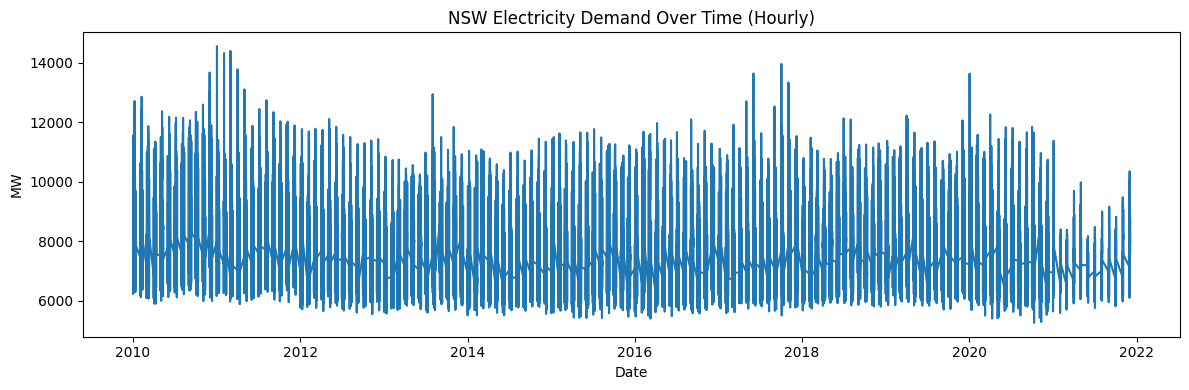

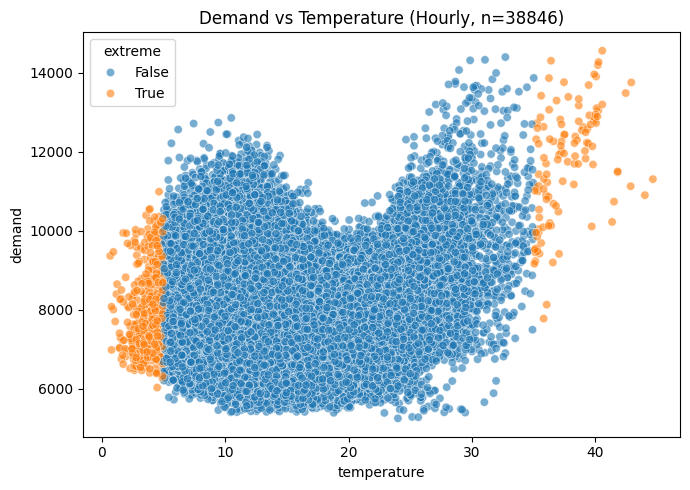

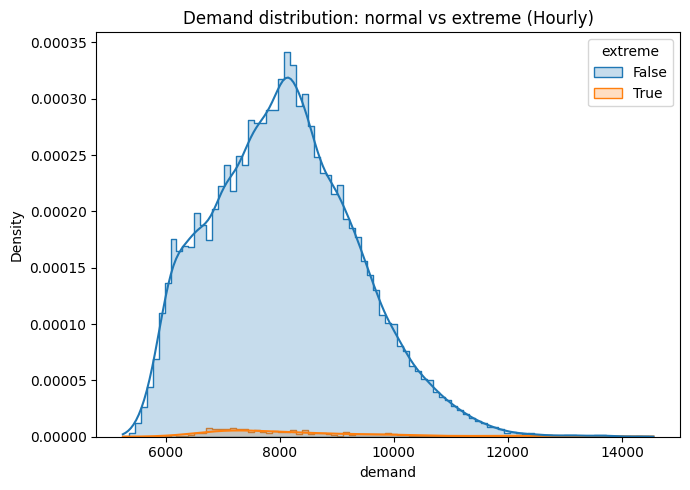

✅ Figures → /content/drive/MyDrive/group d assignment/report/figures


In [9]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

parq = PROC/'nsw_hourly.parquet'
csv  = PROC/'nsw_hourly.csv'

if parq.exists():
    df = pd.read_parquet(parq)
elif csv.exists():
    df = pd.read_csv(csv, parse_dates=['date'])
else:
    raise FileNotFoundError(f"Didn't find {parq} or {csv}. Please run Cell 3 again.")

# Tables
desc = df[['demand','temperature','extreme']].describe(include='all')
desc.to_csv(TAB/'eda_descriptives.csv', index=True)
ext = df.groupby('extreme')[['demand','temperature']].agg(['mean','std','min','max','count'])
ext.to_csv(TAB/'eda_extreme_vs_normal.csv')
print("🗂️ Tables →", TAB)

# Plots
FIG.mkdir(parents=True, exist_ok=True)
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['demand'])
plt.title('NSW Electricity Demand Over Time (Hourly)'); plt.xlabel('Date'); plt.ylabel('MW')
plt.tight_layout(); plt.savefig(FIG/'demand_over_time.png', dpi=160); plt.show()

samp = df.sample(n=min(50_000, len(df)), random_state=42) if len(df)>50_000 else df
plt.figure(figsize=(7,5))
sns.scatterplot(data=samp, x='temperature', y='demand', hue='extreme', alpha=0.6)
plt.title(f'Demand vs Temperature (Hourly, n={len(samp)})')
plt.tight_layout(); plt.savefig(FIG/'demand_vs_temperature.png', dpi=160); plt.show()

plt.figure(figsize=(7,5))
sns.histplot(data=df, x='demand', hue='extreme', kde=True, element='step', stat='density')
plt.title('Demand distribution: normal vs extreme (Hourly)')
plt.tight_layout(); plt.savefig(FIG/'demand_distribution_extreme_vs_normal.png', dpi=160); plt.show()

print("✅ Figures →", FIG)


✅ Baseline done. RMSE=1,259.64, MAE=1,007.46


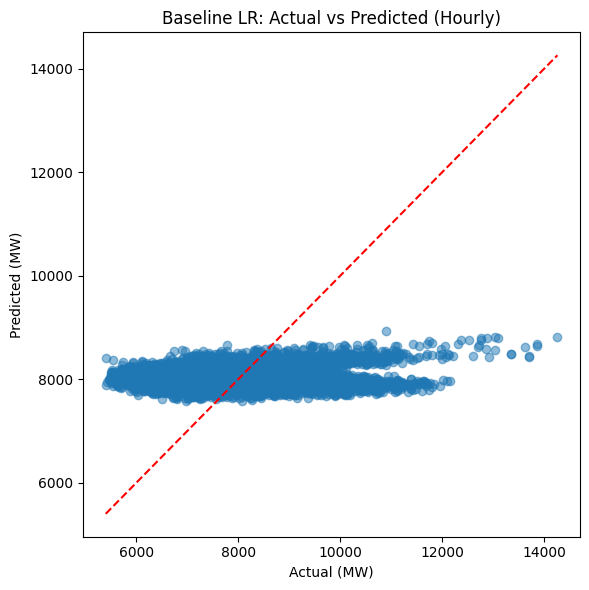

In [10]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = pd.read_parquet(PROC/'nsw_hourly.parquet')

X = df[['temperature']]; y = df['demand']
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LinearRegression().fit(Xtr, ytr); yhat = lr.predict(Xte)

rmse = float(np.sqrt(mean_squared_error(yte, yhat)))
mae  = float(mean_absolute_error(yte, yhat))
pd.DataFrame({'metric':['RMSE','MAE'], 'value':[rmse, mae]}).to_csv(TAB/'baseline_metrics_real_only.csv', index=False)
print(f"✅ Baseline done. RMSE={rmse:,.2f}, MAE={mae:,.2f}")

plt.figure(figsize=(6,6))
plt.scatter(yte, yhat, alpha=0.5)
mn, mx = yte.min(), yte.max(); plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel('Actual (MW)'); plt.ylabel('Predicted (MW)')
plt.title('Baseline LR: Actual vs Predicted (Hourly)')
plt.tight_layout(); plt.savefig(FIG/'baseline_actual_vs_pred.png', dpi=160); plt.show()
